Using a Normalizing Flow to generate image embeddings

# Libraries and Configuration



In [1]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.nn import functional as F

# --- configuration --- #
BATCH_SIZE = 100
INPUT_DIM = 28*28
OUTPUT_DIM = 28*28
N_COUPLE_LAYERS = 4
HIDDEN_DIM = 256
LOG_INTERVAL = 50
EPOCHS = 200
SAVE_PLT_INTERVAL = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load dataset

In [2]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    return train_loader, test_loader

# Base Models

## CouplingLayer


In [3]:
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask):
        super().__init__()
        self.s_fc1 = nn.Linear(input_dim, hid_dim)
        self.s_fc2 = nn.Linear(hid_dim, hid_dim)
        self.s_fc3 = nn.Linear(hid_dim, output_dim)
        self.t_fc1 = nn.Linear(input_dim, hid_dim)
        self.t_fc2 = nn.Linear(hid_dim, hid_dim)
        self.t_fc3 = nn.Linear(hid_dim, output_dim)
        self.mask = mask

    def forward(self, x):
        x_m = x * self.mask

        x1 = F.relu(self.s_fc1(x_m))
        x2 = F.relu(self.s_fc2(x1))
        x3 = F.relu(self.s_fc3(x2))
        s_out = torch.tanh(x3)

        x1_t = F.relu(self.t_fc1(x_m))
        x2_t = F.relu(self.t_fc2(x1_t))
        t_out = self.t_fc3(x2_t)

        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)

        return y, log_det_jacobian

    def backward(self, y):
        y_m = y * self.mask

        y1_s = F.relu(self.s_fc1(y_m))
        y2_s = F.relu(self.s_fc2(y1_s))
        s_out = torch.tanh(self.s_fc3(y2_s))

        y1_t = F.relu(self.t_fc1(y_m))
        y2_t = F.relu(self.t_fc2(y1_t))
        t_out = self.t_fc3(y2_t)


        x = y_m + (1-self.mask)*(y-t_out)*torch.exp(-s_out)
        return x


## RealNVP Model

In [4]:
class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask, n_layers = 6):
        super().__init__()
        assert n_layers >= 2, 'num of coupling layers should be greater or equal to 2'

        self.modules = []
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask).to(device))
        
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))

        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0 # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def backward(self, z):
        for module in reversed(self.module_list):
            z = module.backward(z)
        return z



# Run model

## Train

In [5]:
def train(epoch, model, train_loader, device, optimizer, prior_z):
  model.train()
  train_loss = 0


  for batch_idx, (xu, yu) in enumerate(train_loader):
    xu = xu.reshape(xu.size(0), -1).to(device)
    yu = yu.new(np.eye(10)[yu]).to(device).float()
    # print(xu.shape)

    optimizer.zero_grad()

    z, log_det_j_sum = model(xu)

    log_prob_z = prior_z.log_prob(z.cpu())
    loss = -torch.mean((log_prob_z + log_det_j_sum.cpu()))


    loss.backward()
    cur_loss = loss.item()
    train_loss += cur_loss
    optimizer.step()

  train_loss /= len(train_loader.dataset)

  if epoch%20==0:
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))

  return train_loss, model

## Test

In [6]:
def test(epoch, model, test_loader, device, prior_z):


  model.eval()
  test_loss = 0

  with torch.no_grad():
      for batch_idx, (xu,yu) in enumerate(test_loader):
        xu = xu.to(device).reshape(xu.size(0), -1)

        yu = yu.new(np.eye(10)[yu]).to(device).float()

        z, log_det_j_sum = model(xu)

        log_prob_z = prior_z.log_prob(z.cpu())
        cur_loss = -torch.mean((log_prob_z + log_det_j_sum.cpu())).item()


        test_loss += cur_loss


      test_loss /= len(test_loader.dataset)
      if epoch%20==0:
        print('====> Test set loss: {:.4f}'.format(test_loss))

  return test_loss

## Run

In [7]:
train_loader, test_loader = get_mnist_data(device, BATCH_SIZE)

In [8]:
zeros_half = torch.zeros((BATCH_SIZE, INPUT_DIM // 2), dtype=torch.float).to(device)
ones_half = torch.ones((BATCH_SIZE, INPUT_DIM // 2), dtype=torch.float).to(device)
mask = torch.cat((zeros_half, ones_half), dim=1)

model = RealNVP(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, mask, N_COUPLE_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = MultivariateNormal(torch.zeros(INPUT_DIM), torch.eye(INPUT_DIM))


In [9]:
log_train = []
log_test = []
for epoch in range(1, EPOCHS + 1):
    train_loss, trained_model = train(epoch, model, train_loader, device, optimizer, prior_z)
    test_loss = test(epoch, model, train_loader, device, prior_z)
    log_train.append(train_loss)
    log_test.append(test_loss)

====> Epoch: 20 Average loss: -20.9122
====> Test set loss: -20.9367
====> Epoch: 40 Average loss: -21.5706
====> Test set loss: -21.6012
====> Epoch: 60 Average loss: -21.8713
====> Test set loss: -21.8720
====> Epoch: 80 Average loss: -22.0957
====> Test set loss: -22.1014
====> Epoch: 100 Average loss: -22.2617
====> Test set loss: -22.2705
====> Epoch: 120 Average loss: -22.3780
====> Test set loss: -22.3825
====> Epoch: 140 Average loss: -22.4960
====> Test set loss: -22.5028
====> Epoch: 160 Average loss: -22.5431
====> Test set loss: -22.5382
====> Epoch: 180 Average loss: -22.6135
====> Test set loss: -22.6125
====> Epoch: 200 Average loss: -22.6622
====> Test set loss: -22.6524


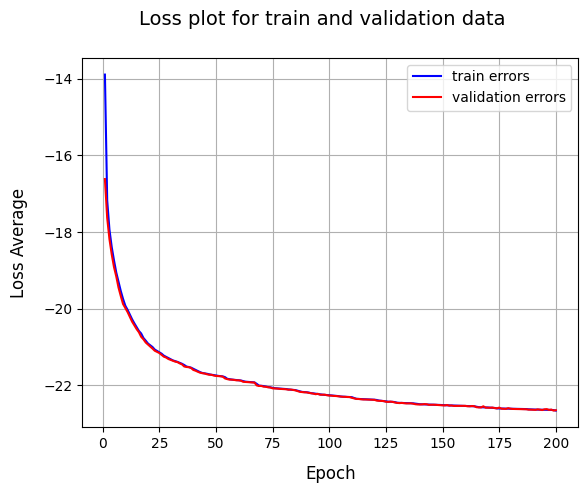

In [10]:
import matplotlib.pyplot as plt

plt.suptitle("Loss plot for train and validation data", size=14)
plt.plot(list(range(1, len(log_train)+1)), log_train, 'b', label='train errors')
plt.plot(list(range(1, len(log_test)+1)), log_test, 'r', label='validation errors')
plt.ylabel('Loss Average', size=12, labelpad=11)
plt.xlabel('Epoch', size=12, labelpad=10)
plt.legend(loc='best', fontsize=10)
plt.grid()

plt.show()

# Sampling

In [11]:
def sample_x(model, prior_z):
    model.eval()
    with torch.no_grad():
        z = prior_z.sample((100,)).to(device)
        x = model.backward(z)
        z, x = z.cpu().detach().numpy(), x.cpu().detach().numpy()
    return x


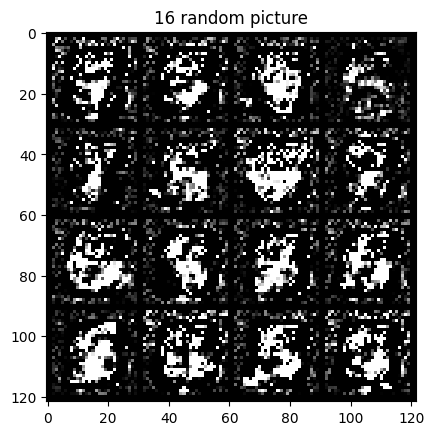

In [14]:
from torchvision.utils import make_grid
from matplotlib.pyplot import imshow
n = 16



samples = (sample_x(model, prior_z)[:n, :]).reshape(n,1,28,28)
grid = make_grid(torch.tensor(samples).cpu(), nrow=int(np.sqrt(n)))
plt.title(str(n)+' random picture')
imshow(grid.permute(1,2,0), cmap='gray');